# SST: Analysis for Item Test

###Procedure

**Session 1**: 

1. Watch 4 videos of each town (2/town in a row)
2. <span style="color:red"> Item test (run 1)</span>
3. Navigation with arrows (2/town)
4. <span style="color:red">Item test (run 2)</span>

**Session 2**:

1. Watch 1 video of each town (2 for subjects 1-4)
2. <span style="color:red">Item test (run 3)</span>
3. Navigation with arrows (2/town)
4. Free navigation without arrows (2/town)
5. <span style="color:red">Item test (run 4)</span>

**Session 3**:

1. Test trials, navigate to item in each environment (2 cycles)
2. Questionnaire about strategies used, etc.
3. <span style="color:red">Item test (run 5)</span>
4. Map drawing
5. Spatial preference questionnaire

### Item test: 
Present subjects with image from town, and asked to recall the 3 items located within that town and to type the names of the items. If they didn't remember an item, they responded with a "?".


Sample image from town:

![env3](./images/env3.jpg)


## Import packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as op
import numpy as np

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
# %load_ext rpy2.ipython
# %R require(lme4)
# %R require(lmerTest)

/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Define color palette

In [2]:
palette = {'face': 'orange',
           'animal': 'dodgerblue',
           'object': 'lightseagreen',
           'food':  'mediumseagreen',
           'fruitveg':  'mediumseagreen',
           'tool': 'mediumpurple'}

## Setup paths

In [7]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')
dirs['object_cat_file'] = op.join(dirs['datadir'], 'object_cat.csv')

In [10]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)

subj_info

,subid,remove
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN
5,6,NaN
6,7,NaN
7,9,NaN
8,10,NaN
9,11,NaN


In [11]:
#Load in file w/object sub-categories for each town, convert to dict
obj_cat = pd.read_csv(dirs['object_cat_file'])
obj_cat = obj_cat.set_index('town').to_dict()['object_cat']

## Load in data

In [12]:
dt = pd.DataFrame() 
test = True
questionnaires_post = True

for subid in subj_info.subid:
    print subid

    if test:
        # add test file
        test_file = op.join(dirs['datadir'], subid, subid + '_behav_itemTest_coded.csv')
        d2 = pd.read_csv(test_file)
        d2['subid'] = subid
        dt = dt.append(d2, ignore_index=True)
        
# Compiled group data
if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)
    dq_post['subid'] = dq_post.subid.astype(str)

1
2
3
4
5
6
7
9
10
11
12
13


IOError: File /Users/sgagnon/Experiments/SST/data/13/13_behav_itemTest_coded.csv does not exist

In [8]:
dt.head()

,index,run,trial,onset,duration,town,pic,itemNum,resp,respRT,itemType,acc,subid
0,1,1,1,1.0020,58.2601,Town6,env6,1,goat clooney lettuce,46.9638,animal,0,1
1,2,1,1,1.0020,58.2601,Town6,env6,2,lettuce,6.7958,object,0,1
2,3,1,1,1.0020,58.2601,Town6,env6,3,clonney,4.4965,face,0,1
3,4,1,2,59.3028,30.2167,Town1,env1,1,cow,7.7858,animal,0,1
4,5,1,2,59.3028,30.2167,Town1,env1,2,?,20.4377,face,0,1


#### Add in sub-type for objects

In [9]:
dt['itemType_sub'] = dt.itemType
dt.ix[dt.itemType == 'object', 'itemType_sub'] = dt[dt.itemType == 'object'].town.map(obj_cat.get)
dt.head()

,index,run,trial,onset,duration,town,pic,itemNum,resp,respRT,itemType,acc,subid,itemType_sub
0,1,1,1,1.0020,58.2601,Town6,env6,1,goat clooney lettuce,46.9638,animal,0,1,animal
1,2,1,1,1.0020,58.2601,Town6,env6,2,lettuce,6.7958,object,0,1,tool
2,3,1,1,1.0020,58.2601,Town6,env6,3,clonney,4.4965,face,0,1,face
3,4,1,2,59.3028,30.2167,Town1,env1,1,cow,7.7858,animal,0,1,animal
4,5,1,2,59.3028,30.2167,Town1,env1,2,?,20.4377,face,0,1,face


In [10]:
dq_post.head()

,subid,compass,generalSOD,landmark,route,survey,surveySpatial,verbalSpatial,survey_pref
0,11,4,11,8,8,5,4,3,-3
1,12,8,16,8,6,5,4,4,-3
2,2,9,18,8,8,8,4,2,0
3,3,11,19,6,3,8,3,4,2
4,4,5,18,8,10,6,3,2,-2


## Analysis

/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(0, 1)

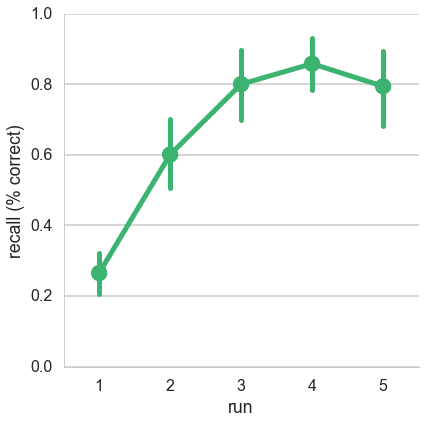

In [11]:
data = dt.groupby(['subid', 'run']).mean().reset_index()
data['recall (% correct)'] = data.acc
sns.factorplot(x='run', y='recall (% correct)', 
               dodge=.2,
               units='subid', ci=68, data=data,
               color='mediumseagreen', size=6)
plt.ylim(0,1)

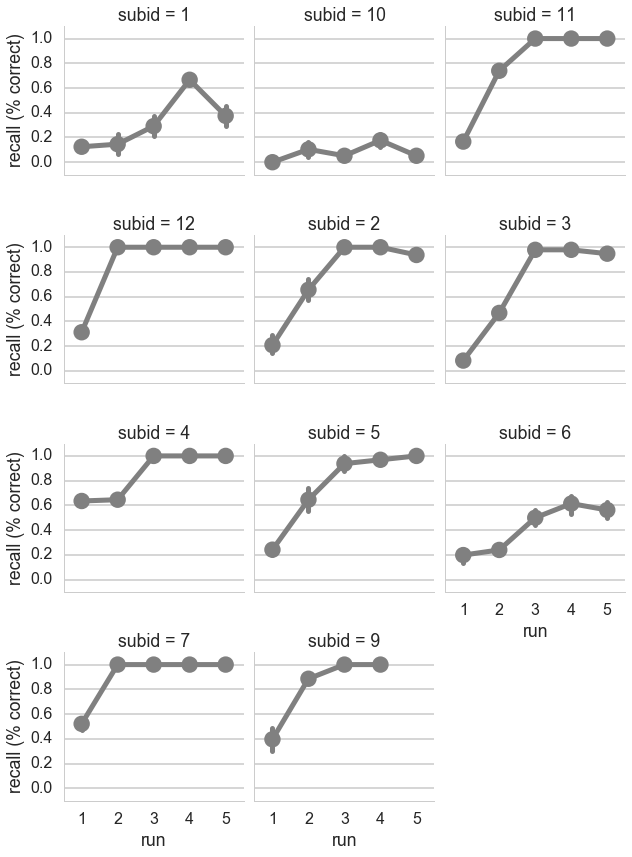

In [12]:
data = dt.groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
data['recall (% correct)'] = data.acc
sns.factorplot(x='run', y='recall (% correct)', 
               dodge=.1, ci=68,
               col='subid', col_wrap=3, data=data,
               color='gray', size=3)
plt.ylim(-.1,1.1)

plt.savefig('/Volumes/group/awagner/sgagnon/SST/analysis/behav/bysub_itemtest_acc.png')

### Accuracy across runs, by type of item

In [13]:
palette

{'animal': 'dodgerblue',
 'face': 'orange',
 'food': 'mediumseagreen',
 'fruitveg': 'mediumseagreen',
 'object': 'lightseagreen',
 'tool': 'mediumpurple'}

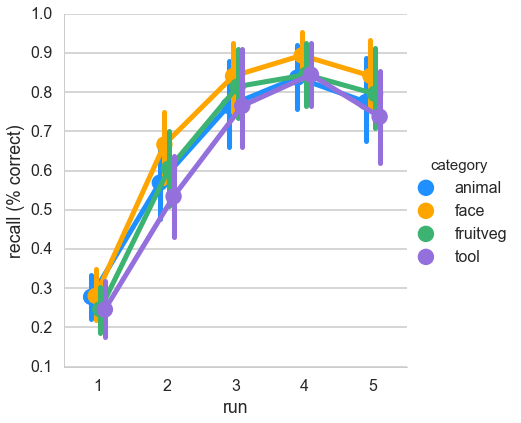

In [13]:
data = dt.groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
data['category'] = data.itemType_sub
data['recall (% correct)'] = data.acc
sns.factorplot(x='run', y='recall (% correct)', hue='category',
               dodge=.2,
               units='subid', ci=68, data=data,
               palette=palette, size=6)
# plt.title()
plt.savefig('/Volumes/group/awagner/sgagnon/SST/analysis/behav/group_itemtest_acc.png')

#### Mean accuracy and standard error for final training (4th) run

In [15]:
data = dt[dt.run == 4].groupby(['itemType_sub']).mean().reset_index()[['itemType_sub', 'acc']]
data['st.err'] = dt[dt.run == 4].groupby(['itemType_sub']).std().reset_index()[['acc']]/subj_info.subid.size
data

,itemType_sub,acc,st.err
0,animal,0.947368,0.024976
1,face,0.972222,0.018345
2,fruitveg,0.942857,0.025977
3,tool,0.942857,0.025977


In [16]:
data = dt[dt.run == 4].groupby('subid').mean().reset_index()
data.describe()

,index,run,trial,onset,duration,itemNum,respRT,acc
count,9.0,9,9.0,9.000000,9.000000,9,9.000000,9.000000
mean,126.5,4,6.5,77.852501,13.893754,2,4.630571,0.953704
std,0.0,0,0.0,13.870211,2.347189,0,0.782393,0.118667
min,126.5,4,6.5,58.632325,9.888600,2,3.295511,0.638889
25%,126.5,4,6.5,68.200383,12.470608,2,4.156206,0.972222
50%,126.5,4,6.5,72.974550,14.020567,2,4.672833,1.000000
75%,126.5,4,6.5,88.719008,15.513892,2,5.170636,1.000000
max,126.5,4,6.5,100.039917,17.996692,2,5.998214,1.000000


#### Broken down by subject

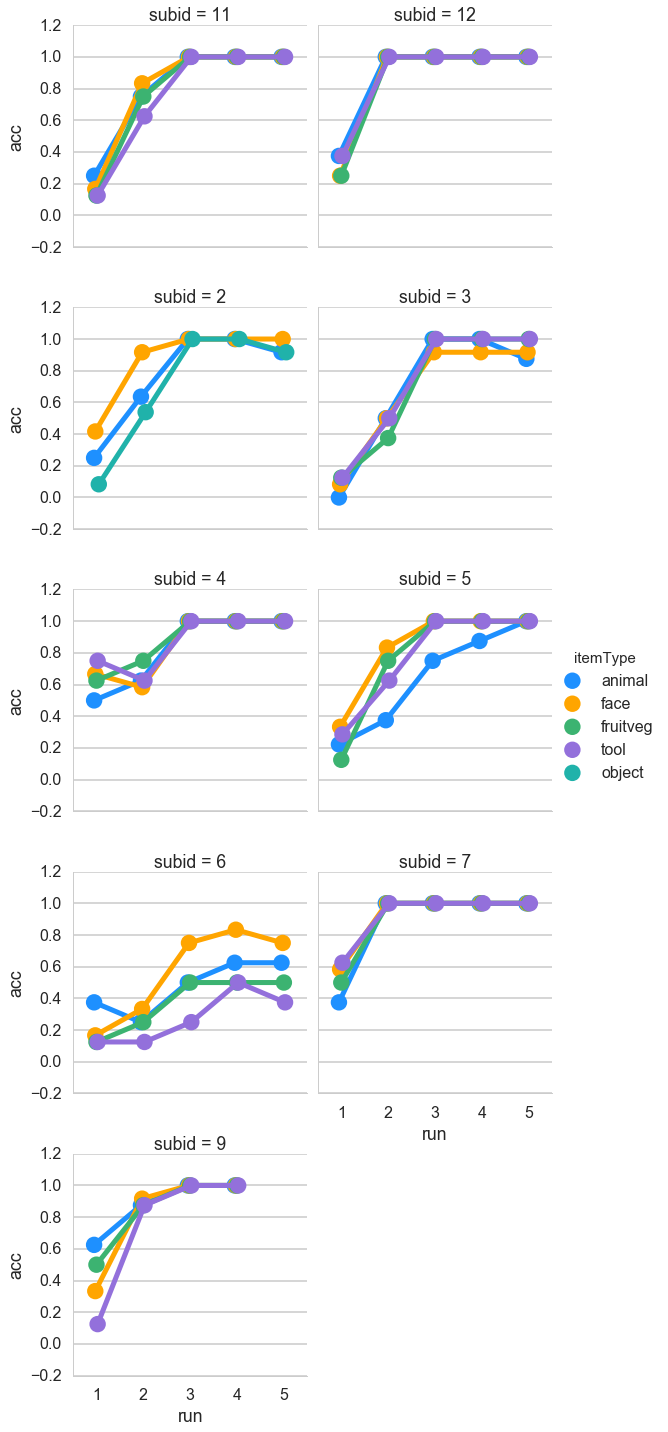

In [17]:
data = dt.groupby(['subid', 'run', 'itemType']).mean().reset_index()
sns.factorplot(x='run', y='acc', hue='itemType',
               dodge=.1,
               col='subid', col_wrap=2, data=data,
               palette=palette)

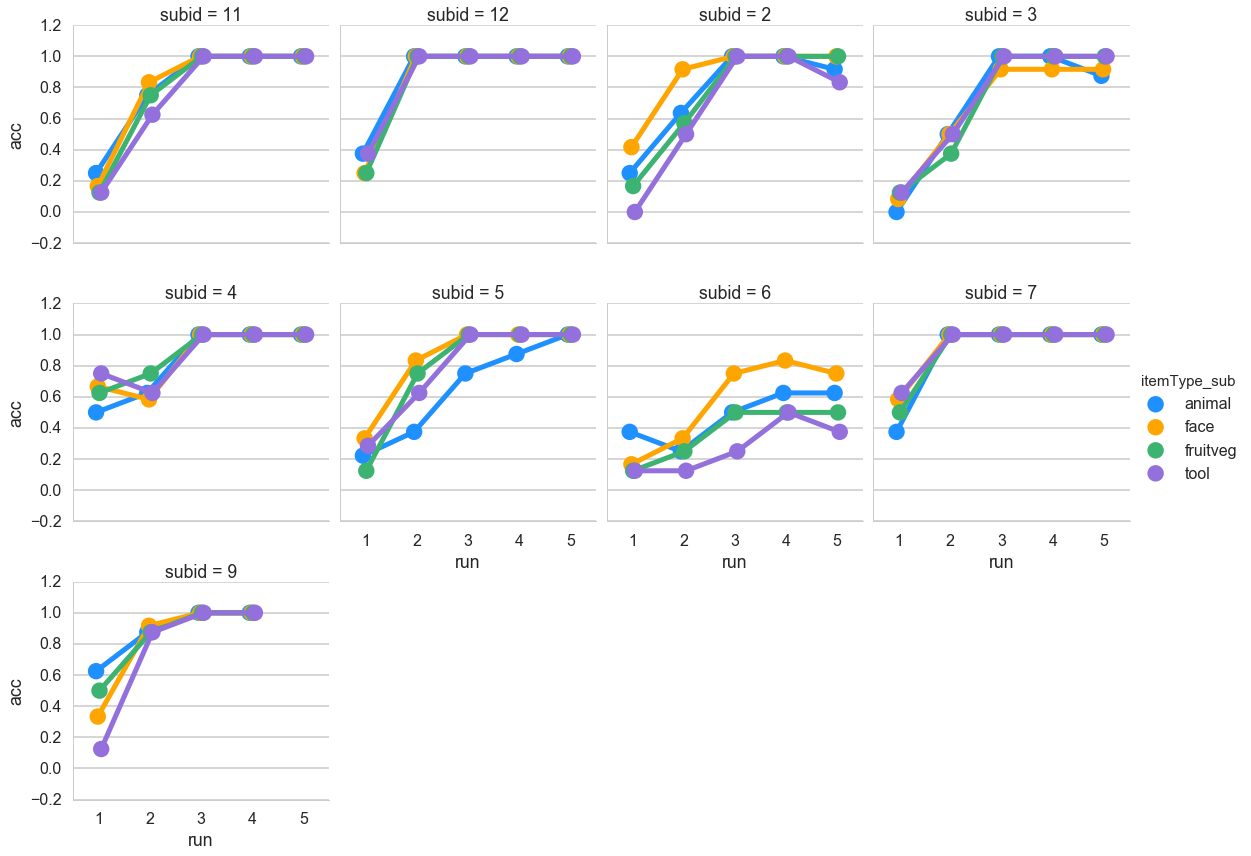

In [18]:
data = dt.groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='run', y='acc', hue='itemType_sub',
               dodge=.1,
               col='subid', col_wrap=4, data=data,
               palette=palette)

### Final training accuracy for item types

In [19]:
data = dt[dt.run == 4].groupby(['subid']).mean().reset_index()
data[data.subid.isin(['1', '2', '3', '4', '7', '8'])].describe()

,index,run,trial,onset,duration,itemNum,respRT,acc
count,4.0,4,4.0,4.000000,4.000000,4,4.000000,4.000000
mean,126.5,4,6.5,72.707569,13.026185,2,4.341385,0.993056
std,0.0,0,0.0,14.114292,2.435496,0,0.811838,0.013889
min,126.5,4,6.5,58.632325,9.888600,2,3.295511,0.972222
25%,126.5,4,6.5,65.118381,11.825106,2,3.941032,0.993056
50%,126.5,4,6.5,70.127475,13.351125,2,4.449696,1.000000
75%,126.5,4,6.5,77.716662,14.552204,2,4.850049,1.000000
max,126.5,4,6.5,91.943000,15.513892,2,5.170636,1.000000


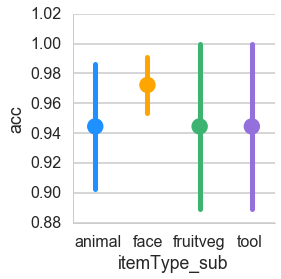

In [20]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='acc', hue='itemType_sub',
               dodge=.1,
               units='subid', ci=68, data=data, palette=palette)

### How does final training accuracy relate to spatial preference?

In [21]:
data = dt[dt.run == 4].groupby(['subid']).mean().reset_index()
data = data.merge(dq_post, on='subid')

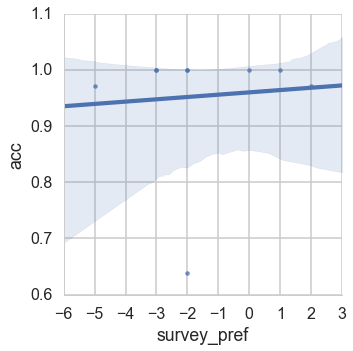

In [22]:
sns.lmplot(x='survey_pref', y='acc', 
           data=data)

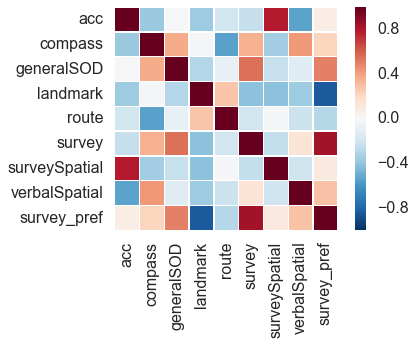

In [23]:
data = dt[dt.run == 4].groupby(['subid']).mean().reset_index()
data = data.merge(dq_post, on='subid')
dsub = data.ix[:,8:].T
sns.heatmap(np.corrcoef(dsub), 
            xticklabels=dsub.index,
            yticklabels=dsub.index,
            square=True)

#### Statistical difference between acc for different item types?

In [162]:
data = dt[dt.run == 4].groupby(['itemType_sub', 'subid', 'town']).mean().reset_index()[['subid', 'itemType_sub', 'acc', 'town']]
%R -i data

ERROR: Line magic function `%R` not found.


In [163]:
%%R

res1 = lmer(acc ~ itemType_sub + (1 | subid) + (1 | town), data=data)
res2 = lmer(acc ~ itemType_sub + (1 | subid), data=data)
print(anova(res2, res1, refit=FALSE))

print(summary(res1))

ERROR: Cell magic `%%R` not found.


### Final training (run 4) accuracy across environments

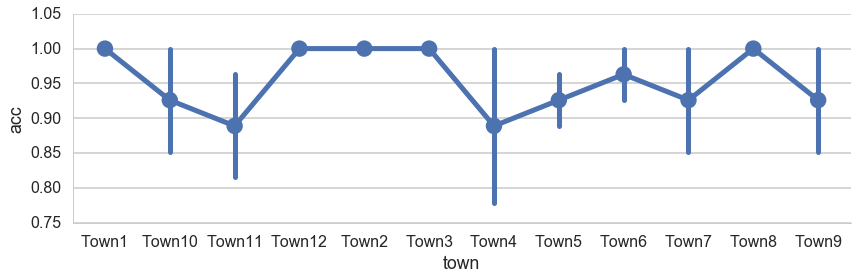

In [24]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'town']).mean().reset_index()
sns.factorplot(x='town', y='acc', 
               dodge=.1, aspect=3,
               units='subid', ci=68, data=data)

#### Broken down by item type for each town

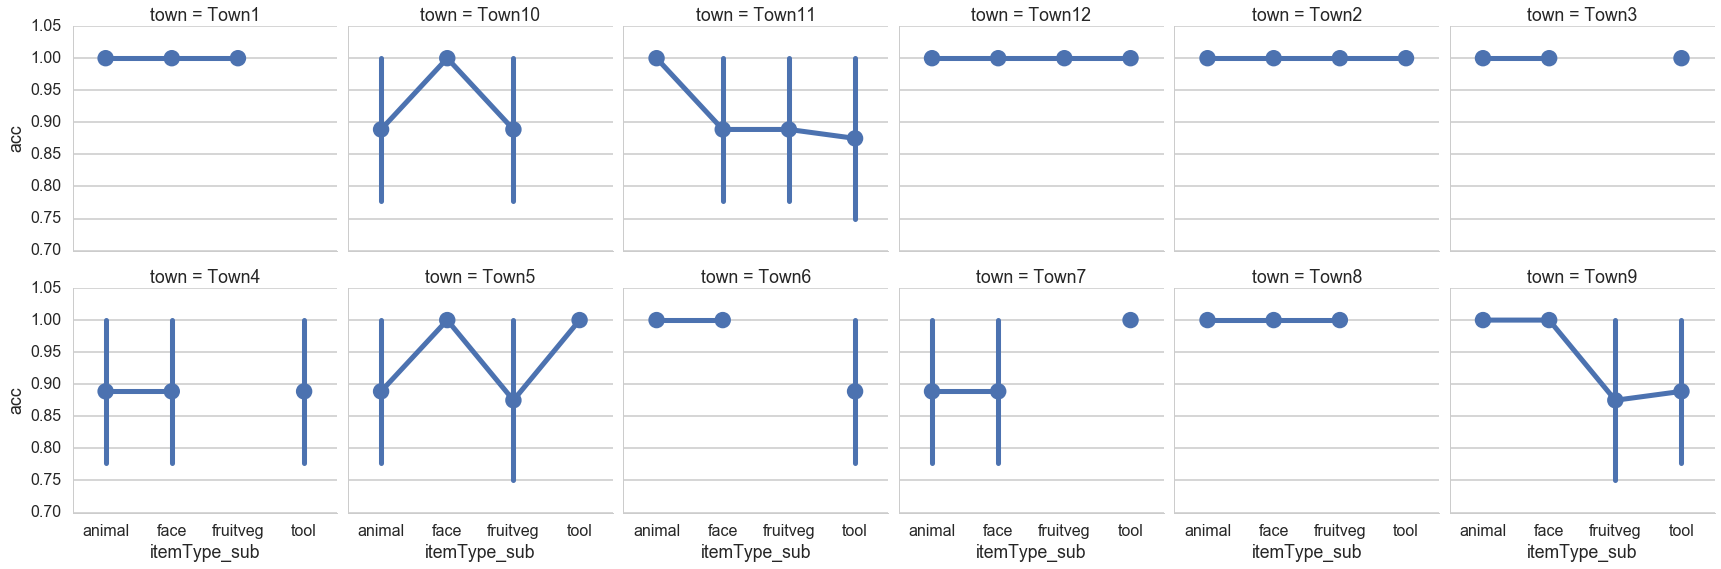

In [25]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'town', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='acc', col='town', col_wrap=6,
               dodge=0, aspect=1, 
               units='subid', ci=68, data=data)

### Order of recalling items

#### Correct recall, run 4

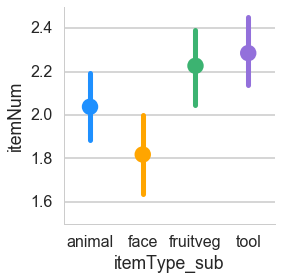

In [26]:
data = dt[(dt.acc == 1) & (dt.run==4)].groupby(['subid', 'itemNum', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='itemNum', 
               dodge=.1,
               units='subid', ci=68, data=data, palette=palette)

In [167]:
%R -i data

ERROR: Line magic function `%R` not found.


In [168]:
%%R 
print(str(data))
df <- within(data, itemType_sub <- relevel(itemType_sub, ref =2))
print(summary(lmer(itemNum ~ itemType_sub + (1 | subid), data=df)))

ERROR: Cell magic `%%R` not found.


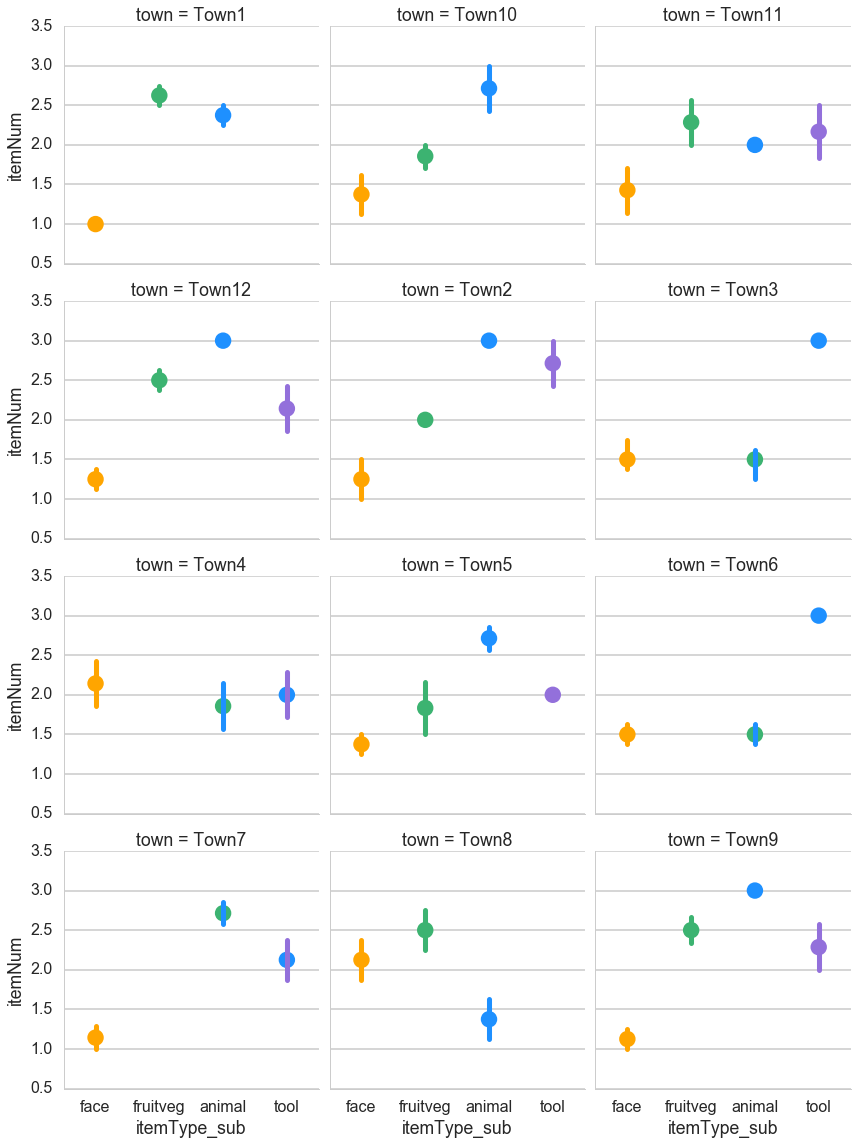

In [169]:
data = dt[(dt.acc == 1) & (dt.run==4)].groupby(['subid', 'town', 'itemNum', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='itemNum', 
               dodge=.1, col='town', col_wrap=3,
               units='subid', ci=68, data=data, palette=palette)

#### Correct recall, across runs

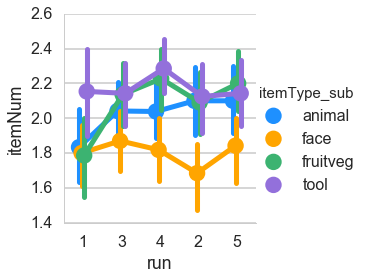

In [27]:
data = dt[(dt.acc == 1)].groupby(['subid', 'itemNum', 'itemType_sub', 'run']).mean().reset_index()
sns.factorplot(x='run', y='itemNum', hue='itemType_sub',
               dodge=.2,
               units='subid', ci=68, data=data,
               palette=palette)

## RTs for correct responses

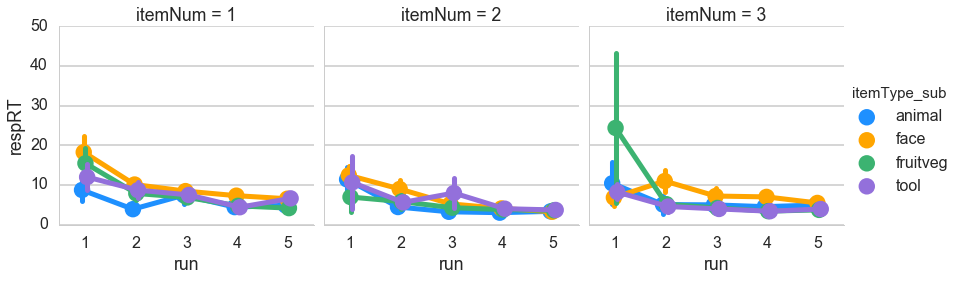

In [28]:
data = dt[dt.acc==1].groupby(['subid', 'run', 'itemType_sub', 'itemNum']).mean().reset_index()
sns.factorplot(x='run', y='respRT', hue='itemType_sub',
               col='itemNum',
               units='subid', ci=68,
               dodge=.1,
               data=data,
               palette=palette)

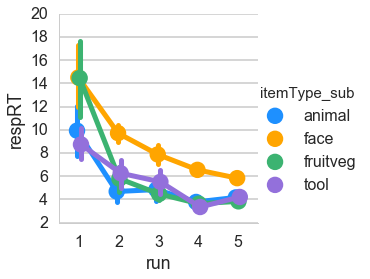

In [30]:
data = dt[dt.acc==1].groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='run', y='respRT', hue='itemType_sub',
               units='subid', ci=68,
               dodge=.1,
               data=data,
               palette=palette)

plt.savefig('/Volumes/group/awagner/sgagnon/SST/analysis/behav/group_itemtest_corr_rt.png')